In [1]:
import kagglehub
import os
import shutil

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn

import cv2
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Download dataset with kagglehub (it will first save to the cache)
dataset_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')
print("Downloaded to cache:", dataset_path)

## Copy dataset to Google Drive
drive_path = "/content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN"
shutil.copytree(dataset_path, drive_path, dirs_exist_ok=True)

print("Dataset copied to Google Drive at:", drive_path)

Using Colab cache for faster access to the 'flowers-recognition' dataset.
Downloaded to cache: /kaggle/input/flowers-recognition
Dataset copied to Google Drive at: /content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN


### Preparing the Data

#### Making the functions to get the training and validation set from the Images

In [4]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/My Drive/OTHM AI/Deep Learning/Image Classification CNN/flowers/rose'

In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)

100%|██████████| 764/764 [00:08<00:00, 90.62it/s] 

764


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)

100%|██████████| 733/733 [00:09<00:00, 75.17it/s] 


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)

100%|██████████| 984/984 [00:10<00:00, 90.31it/s] 


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)

100%|██████████| 1052/1052 [00:12<00:00, 82.80it/s] 


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)

100%|██████████| 784/784 [00:07<00:00, 106.02it/s]


#### Visualizing some Random Images

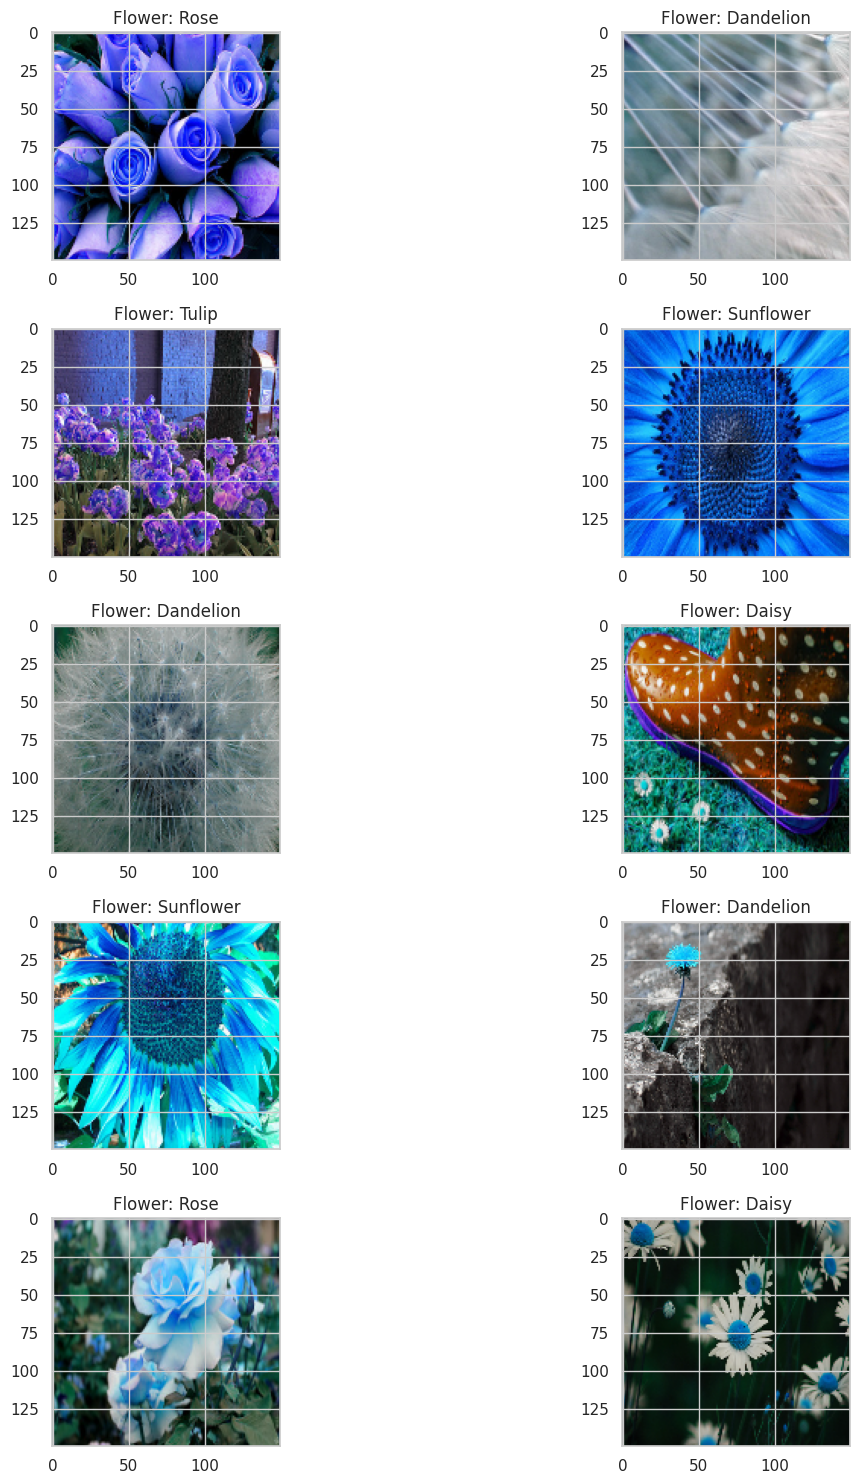

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

#### Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [13]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

#### Splitting into Training and Validation Sets

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [15]:
np.random.seed(42)
rn.seed(42)

### Modelling

#### Building the ConvNet Model

In [16]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

#### Using a LR Annealer

In [17]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

#### Data Augmentation to prevent Overfitting

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

#### Compiling the Keras Model & Summary

In [19]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,143,749 (15.81 MB)

 Trainable params: 4,143,749 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

#### Fitting on the Training set and making predcitons on the Validation set

In [21]:


History = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3214 - loss: 1.5248 - val_accuracy: 0.4546 - val_loss: 1.3041
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5234 - loss: 1.2691 - val_accuracy: 0.4815 - val_loss: 1.2832
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 717ms/step - accuracy: 0.4564 - loss: 1.2753 - val_accuracy: 0.4954 - val_loss: 1.1950
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4453 - loss: 1.2037 - val_accuracy: 0.5222 - val_loss: 1.1823
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 763ms/step - accuracy: 0.5339 - loss: 1.1329 - val_accuracy: 0.5769 - val_loss: 1.0708
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5156 - loss: 1.1560 - val_accuracy: 0.5704 - val_loss: 1.0684
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 704ms/step - accuracy: 0.5697 - loss: 1.0382 - val_accuracy: 0.6500 - val_loss: 0.9672
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5547 - loss: 0.9623 - val_accuracy: 0.650

### Evaluating the Model Performance

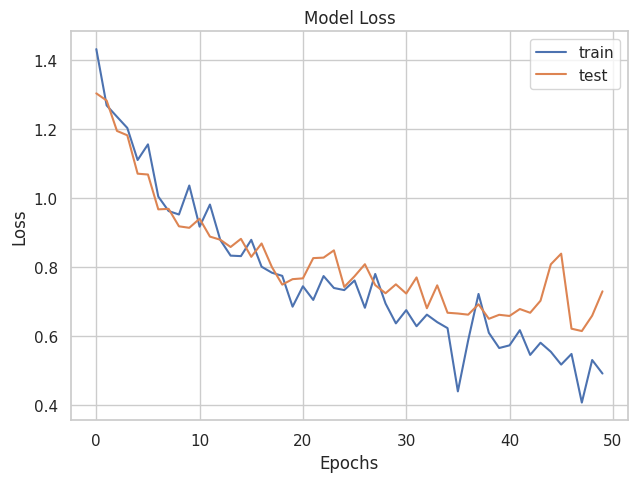

In [22]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

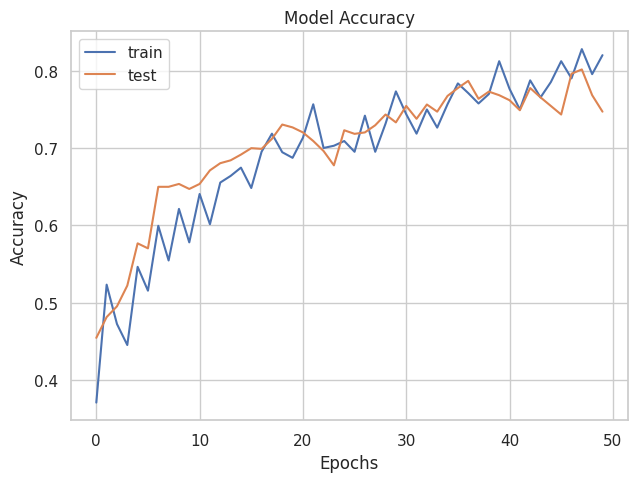

In [23]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Visualizing Predictons on the Validation Set

In [24]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [25]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

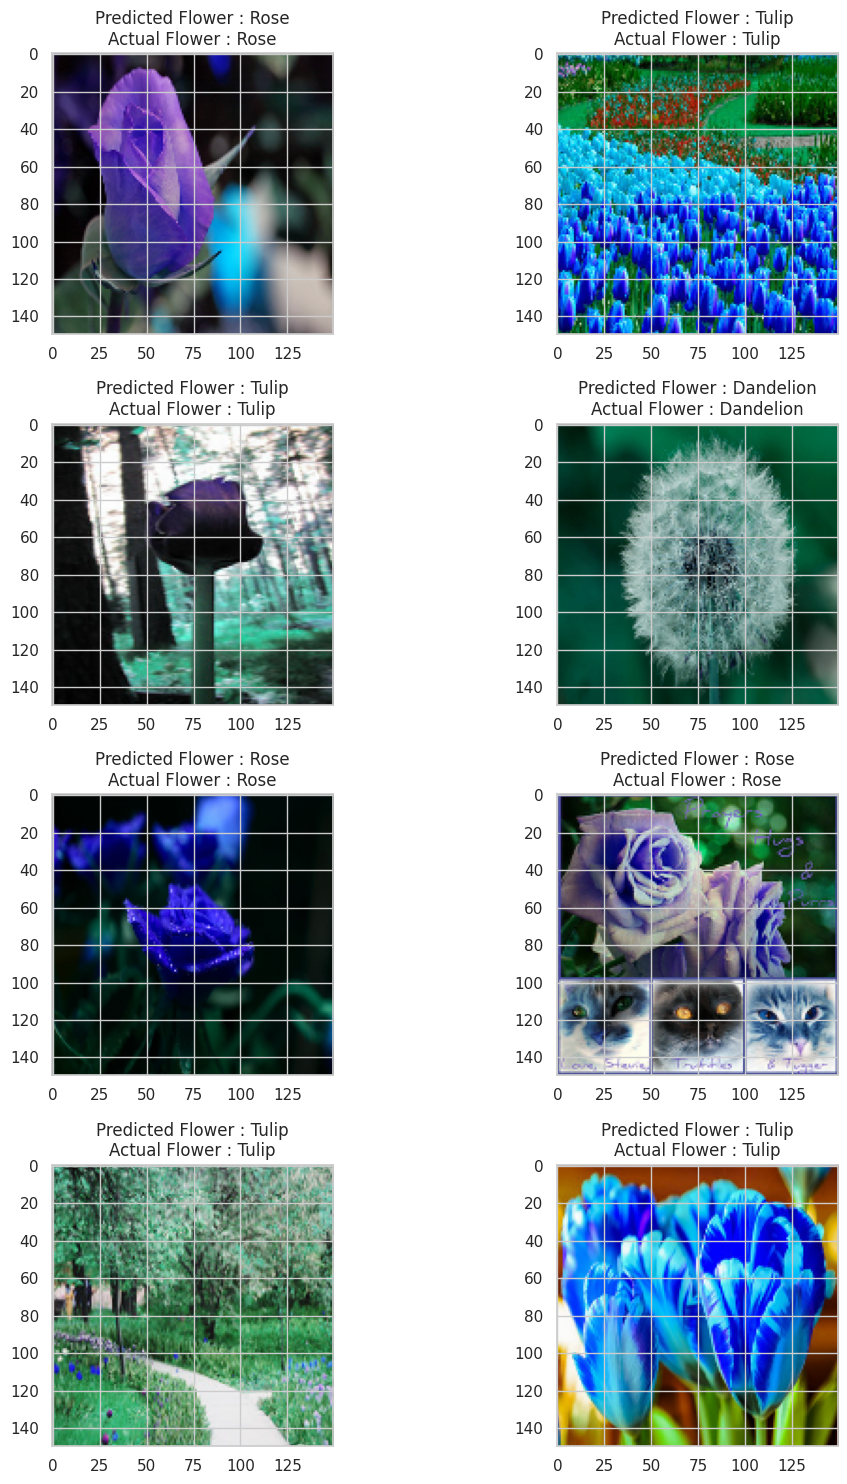

In [26]:
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title(
            "Predicted Flower : "
            + str(le.inverse_transform([pred_digits[prop_class[count]]])[0])
            + "\n"
            + "Actual Flower : "
            + str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0])
        )
        plt.tight_layout()
        count += 1

#### MISCLASSIFIED IMAGES OF FLOWERS

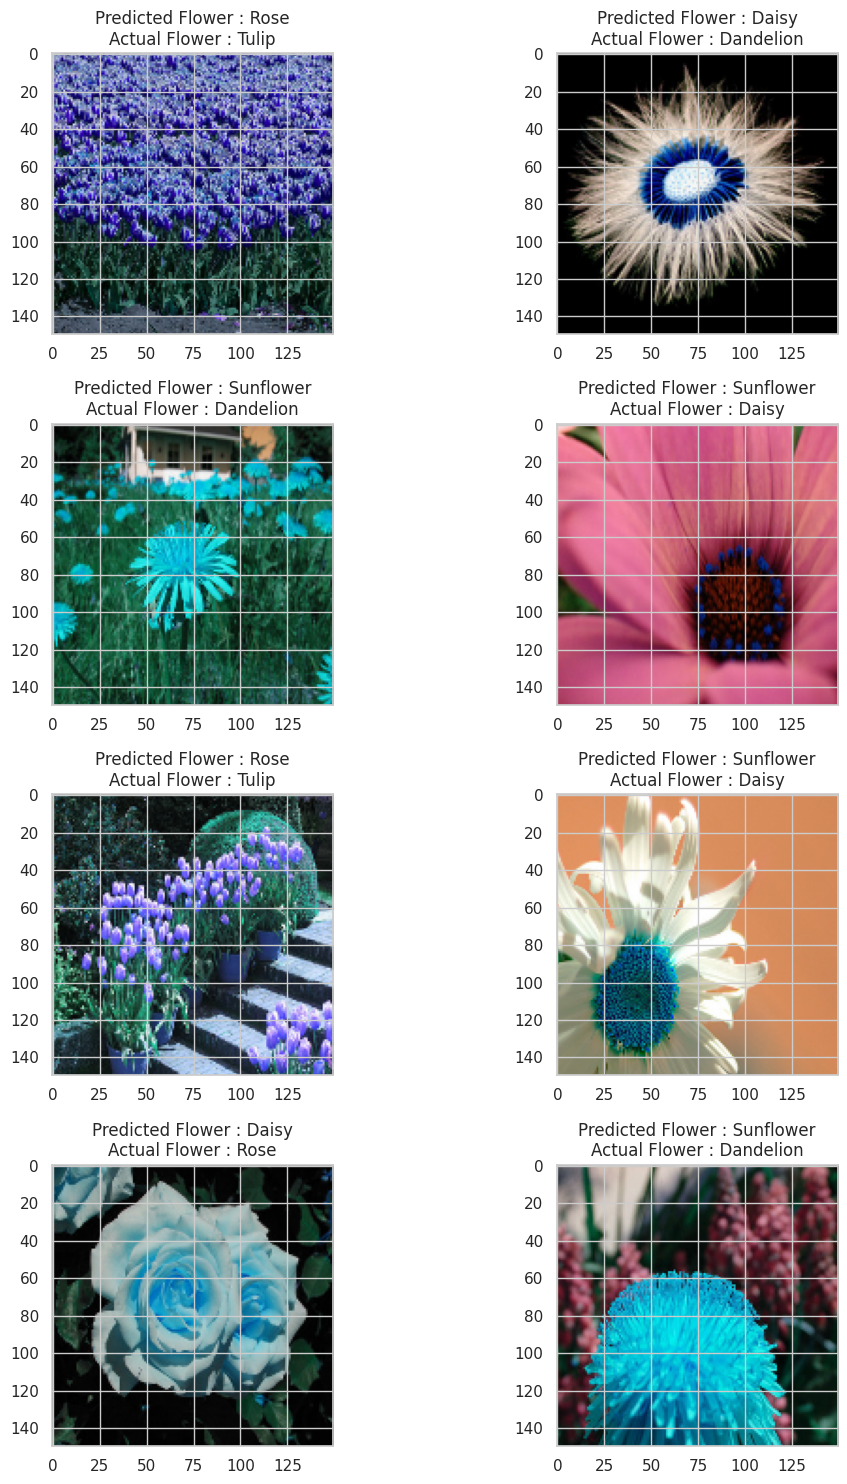

In [27]:
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]])
        ax[i, j].set_title(
            "Predicted Flower : "
            + str(le.inverse_transform([pred_digits[mis_class[count]]])[0])
            + "\n"
            + "Actual Flower : "
            + str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])[0])
        )
        plt.tight_layout()
        count += 1
